Source Article: 

https://neptune.ai/blog/how-to-implement-customer-churn-prediction
https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset

# Import Libraries

In [1]:
# Load general utilities
# ----------------------
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load sklearn utilities
# ----------------------
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Load classifiers
# ----------------
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# PyTorch Libraries
# -----------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Other Model Packages
# --------------
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN
from catboost import CatBoostClassifier

# Other Libraries
# ---------------
import plotly.express as px

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# Load Telco Dataset

In [2]:
filename = 'EDA_Output.csv'
df = pd.read_csv(filename)

In [3]:
df

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Referred a Friend,Number of Referrals,Tenure in Months,...,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Churn
0,Male,78,No,Yes,No,No,0,No,0,1,...,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,Yes
1,Female,74,No,Yes,Yes,Yes,1,Yes,1,8,...,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,Yes
2,Male,71,No,Yes,No,Yes,3,No,0,18,...,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,Yes
3,Female,78,No,Yes,Yes,Yes,1,Yes,1,25,...,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,Yes
4,Female,80,No,Yes,Yes,Yes,1,Yes,1,37,...,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,30,No,No,No,No,0,No,0,72,...,No,No,No,No,No,Two Year,Yes,Bank Withdrawal,21.15,No
7039,Male,38,No,No,Yes,Yes,2,Yes,1,24,...,Yes,Yes,Yes,Yes,Yes,One Year,Yes,Mailed Check,84.80,No
7040,Female,30,No,No,Yes,Yes,2,Yes,4,72,...,No,Yes,Yes,Yes,Yes,One Year,Yes,Credit Card,103.20,No
7041,Female,32,No,No,Yes,Yes,2,Yes,1,11,...,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,29.60,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  7043 non-null   object 
 1   Age                     7043 non-null   int64  
 2   Under 30                7043 non-null   object 
 3   Senior Citizen          7043 non-null   object 
 4   Married                 7043 non-null   object 
 5   Dependents              7043 non-null   object 
 6   Number of Dependents    7043 non-null   int64  
 7   Referred a Friend       7043 non-null   object 
 8   Number of Referrals     7043 non-null   int64  
 9   Tenure in Months        7043 non-null   int64  
 10  Offer                   7043 non-null   object 
 11  Phone Service           7043 non-null   object 
 12  Multiple Lines          7043 non-null   object 
 13  Internet Service        7043 non-null   object 
 14  Internet Type           7043 non-null   

# Preparing Data for Machine Learning Models

In [5]:
churn = df.copy()
churn = np.where(churn['Churn'] == 'Yes', 1, 0)
churn

array([1, 1, 1, ..., 0, 0, 0])

In [6]:
# Separate features and target
X = df.drop(columns='Churn')
y = churn

We want to view the columns we are using one last time before implementing them in the machine learning models to ensure we aren't including columns that shouldn't be there. 

In [7]:
X.columns

Index(['Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married', 'Dependents',
       'Number of Dependents', 'Referred a Friend', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charge'],
      dtype='object')

In [8]:
# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True, dtype=int)

In [9]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (7043, 35)
y Shape: (7043,)


In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Train Dataset Shape:")
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"\nTest Dataset Shape:")
print(f"X_test Shape:  {X_test.shape}")
print(f"y_test Shape:  {y_test.shape}")

Train Dataset Shape:
X_train Shape: (4930, 35)
y_train Shape: (4930,)

Test Dataset Shape:
X_test Shape:  (2113, 35)
y_test Shape:  (2113,)


The stratify=y parameter helps to maintain the same proportion of the target variable (Churn) in both the training and test sets.

# Classification Models

#### Most of the structure of this section is inspired by the following Kaggle Notebook:

#### https://www.kaggle.com/code/ahmedashrafahmed/customer-churn-prediction-eda-and-model-98-acc#notebook-container

## Baseline Model Accuracy

Summary and Model Explanation

Here’s a brief overview of each model:

1.	RandomForest: A robust model that builds multiple decision trees and combines their results. It’s usually strong for many datasets because it reduces the risk of overfitting on training data.
2.	XGBoost (Extreme Gradient Boosting): A boosting algorithm that sequentially improves weak models, typically strong for structured/tabular data but requires specific libraries (like libomp) for optimal performance.
3.	LGBM (LightGBM): Similar to XGBoost, this model builds trees for faster and efficient boosting. It’s often faster on larger datasets.
4.	DecisionTree: A simpler model that makes decisions based on if-else rules. It can overfit easily, meaning it may not perform as well on new data.
5.	KNN (K-Nearest Neighbors): A non-parametric model that classifies data based on the most common class among nearest neighbors. KNN is sensitive to how data is scaled.
6.	SVC (Support Vector Classifier): This model tries to find the best boundary between classes. It performs better with fewer features and requires careful parameter tuning.
7.	LogisticRegression: A basic model for binary classification that calculates probabilities for each class. Scaling data and more iterations often help improve its convergence.
8.	CatBoost: Another boosting model specifically optimized for categorical features, which is why it’s performing well.
9.	GradientBoosting and AdaBoost: Both are boosting methods that correct errors from weaker models by adjusting weights or modifying the input data. They’re generally strong choices, particularly for structured data.
10.	NaiveBayes: A probabilistic model often used for text classification. It’s less complex but works well for certain types of data.


In [11]:
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=10000),
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', models['LogisticRegression'])
])

### Validation Score
cv_results = {}
for model_name, model in models.items():
    print(f"Cross-validating {model_name}...")
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    cv_results[model_name] = cv_scores.mean()
    print(f"Mean accuracy for {model_name}: {cv_scores.mean():.4f}")

Cross-validating LogisticRegression...
Mean accuracy for LogisticRegression: 0.8432


As can be seen from the above average accuracy for each model, the MLP model outperforms.

In [12]:
cv_results_df = pd.DataFrame(list(cv_results.items()), columns=['Model', 'Mean Accuracy'])
cv_results_df = cv_results_df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
cv_results_df

,Model,Mean Accuracy
0,LogisticRegression,0.843205


In [13]:
best_model_name = cv_results_df.iloc[0]['Model']
print(f"\nBest model from CV: {best_model_name}")


Best model from CV: LogisticRegression


## Optimizing Parameters for Best Cross-Validation Score

##### This next cell takes approximately 12 minutes to run.

### Parameter Grid Explanation for Logistic Regression

In the `param_grids` dictionary, we define the hyperparameters that will be tuned using `GridSearchCV` for the `LogisticRegression` model. Below is a detailed explanation of each parameter:

- **`C`**: This parameter represents the inverse of regularization strength. It controls the amount of regularization applied to the model. A smaller value of `C` implies stronger regularization, which can prevent overfitting but may lead to underfitting if too small. The values in the grid `[0.01, 0.1, 1, 10]` are chosen to test different levels of regularization:
  - `0.01`: High regularization (strong penalty)
  - `0.1`: Moderate regularization
  - `1`: Default value (no additional regularization)
  - `10`: Low regularization (weak penalty)

- **`penalty`**: This parameter specifies the type of regularization used in the model. The options included are:
  - `'l1'`: L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This can lead to sparse solutions (some coefficients may become zero).
  - `'l2'`: L2 regularization, which adds a penalty equal to the square of the magnitude of coefficients. This helps distribute errors uniformly across all coefficients and is more commonly used than L1.

- **`solver`**: This parameter determines the algorithm used to optimize the loss function. The options are:
  - `'liblinear'`: A good choice for smaller datasets and supports L1 and L2 regularization. It works well with `penalty='l1'` and `penalty='l2'`.
  - `'saga'`: An extension of the `sag` solver that supports both L1 and L2 regularization. It is suitable for large-scale datasets and is capable of handling the `penalty='l1'`.

By setting up a grid with these combinations, `GridSearchCV` will perform cross-validation to determine which combination of `C`, `penalty`, and `solver` yields the best model performance based on the chosen scoring metric (`accuracy` in this case).

In [14]:
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
}

best_results = []

# Existing model tuning with GridSearchCV
for model_name, model in models.items():
        print(f"\nPerforming GridSearchCV for {model_name}...")
        grid_search = GridSearchCV(estimator=pipeline[1], param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_results.append({'Model': model_name, 'Best Score': best_score, 'Best Params': best_params})
        print(f"Best parameters for {model_name}: {best_params}")
        print(f"Best cross-validation score for {model_name}: {best_score:.4f}")


Performing GridSearchCV for LogisticRegression...
Best parameters for LogisticRegression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score for LogisticRegression: 0.8434


In [15]:
best_results_df = pd.DataFrame(best_results)
best_results_df = best_results_df.sort_values(by='Best Score', ascending=False)
best_results_df

,Model,Best Score,Best Params
0,LogisticRegression,0.843408,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}"


In [16]:
best_model_name, best_model_param = best_results_df.iloc[0]['Model'], best_results_df.iloc[0]['Best Params']
print(f"\nBest model : {best_model_name}")
print(f"\nBest Parameters : {best_model_param}")


Best model : LogisticRegression

Best Parameters : {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [17]:
best_model_param

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

## Evaluating Best Model

In [18]:
# Using best model determined from GridSearchCV
cv_model = grid_search

# Determining the best model
best_model = cv_model.best_estimator_
print("=========================================================")
print("  Model: L1 Penalized Logistic Regression")
print("=========================================================")
print("Optimal parameters:")
print(f'cv_model.best_params_\n')

# Make predictions on the test and establish ROC Curve
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Make predictions; if we were able to find probabilities, use
# the threshold that maximizes the accuracy in the training set.
y_train_pred_probs = best_model.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

true_pos_train = tpr_train * (y_train.sum())
true_neg_train = (1 - fpr_train) * (1 - y_train).sum()

best_threshold_index = np.argmax(true_pos_train + true_neg_train)
best_threshold = 1 if best_threshold_index == 0 else thresholds_train[best_threshold_index]

print(f'Accuracy-Maximizing Threshold: {str(best_threshold)}')

y_train_preds = (y_train_pred_probs > best_threshold)
y_pred = (y_pred_probs > best_threshold)
print()
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'], digits=4))


  Model: L1 Penalized Logistic Regression
Optimal parameters:
cv_model.best_params_

Accuracy-Maximizing Threshold: 0.5031661604509585

Accuracy: 0.8499763369616659
              precision    recall  f1-score   support

    No Churn     0.8781    0.9240    0.9005      1552
       Churn     0.7542    0.6453    0.6955       561

    accuracy                         0.8500      2113
   macro avg     0.8162    0.7846    0.7980      2113
weighted avg     0.8452    0.8500    0.8460      2113



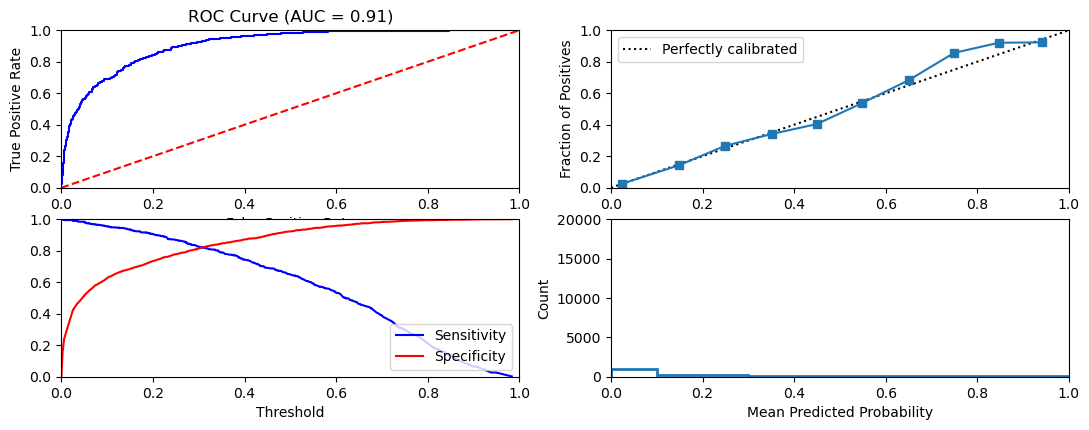

In [19]:
plt.figure(figsize = (13, 4.5))

plt.subplot(2, 2, 1)

plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(2, 2, 3)

plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
plt.legend(loc = 'lower right')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Threshold')

plt.subplot(2, 2, 2)

fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

plt.subplot(2, 2, 4)

plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
plt.xlim([0,1]); plt.ylim([0,20000])
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Count')

plt.show()

In [20]:
y_pred

array([ True, False,  True, ..., False, False, False])

Confusion Matrix:
 [[1434  118]
 [ 199  362]]


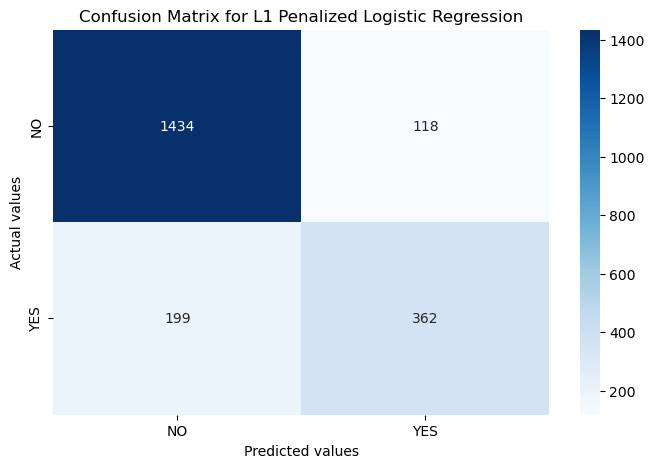

In [21]:
# Confusion Matrix for test set
cm = confusion_matrix(y_test, y_pred=y_pred)
print('Confusion Matrix:\n', cm)
plt.figure(figsize=(8, 5))
sns.heatmap(data=cm, annot=True, fmt='g', cmap="Blues", xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion Matrix for L1 Penalized Logistic Regression')
plt.show()

In [22]:
X.columns

Index(['Age', 'Number of Dependents', 'Number of Referrals',
       'Tenure in Months', 'Monthly Charge', 'Gender_Male', 'Under 30_Yes',
       'Senior Citizen_Yes', 'Married_Yes', 'Dependents_Yes',
       'Referred a Friend_Yes', 'Offer_Offer A', 'Offer_Offer B',
       'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E', 'Phone Service_Yes',
       'Multiple Lines_Yes', 'Internet Service_Yes', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Internet Type_No Internet',
       'Online Security_Yes', 'Online Backup_Yes',
       'Device Protection Plan_Yes', 'Premium Tech Support_Yes',
       'Streaming TV_Yes', 'Streaming Movies_Yes', 'Streaming Music_Yes',
       'Unlimited Data_Yes', 'Contract_One Year', 'Contract_Two Year',
       'Paperless Billing_Yes', 'Payment Method_Credit Card',
       'Payment Method_Mailed Check'],
      dtype='object')

In [23]:
# Extracting the top and bottom index row numbers
top_and_bottom_idx = list(np.argsort(best_model.coef_)[0, :5]) + list(np.argsort(best_model.coef_)[0, -5:])
top_and_bottom_idx

[31, 16, 20, 9, 18, 34, 8, 7, 11, 10]

In [24]:
# Extracing the values based on the index rows
bplot = pd.Series(best_model.coef_[0, top_and_bottom_idx])
bplot

0   -2.786647
1   -2.096674
2   -1.685337
3   -1.502499
4   -1.347874
5    0.540099
6    0.584481
7    0.724653
8    1.293109
9    1.296971
dtype: float64

In [25]:
# Extracting the features based on the highest and lowest coefficients indexes 
xticks = X_train.columns[top_and_bottom_idx]
xticks

Index(['Contract_Two Year', 'Phone Service_Yes', 'Internet Type_Fiber Optic',
       'Dependents_Yes', 'Internet Service_Yes', 'Payment Method_Mailed Check',
       'Married_Yes', 'Senior Citizen_Yes', 'Offer_Offer A',
       'Referred a Friend_Yes'],
      dtype='object')

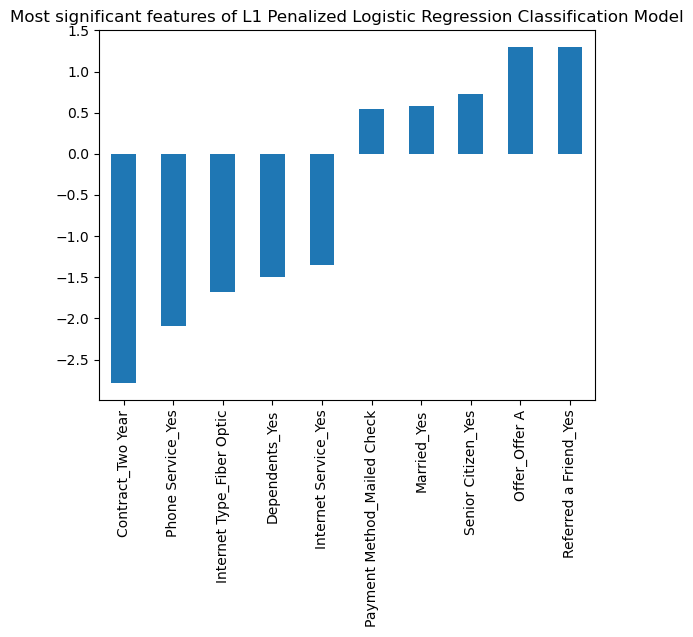

In [26]:
## plot top 3 features with the most positive (and negative) weights 
p1 = bplot.plot(kind='bar',rot=90)
p1.set_xticklabels(xticks)
plt.title('Most significant features of L1 Penalized Logistic Regression Classification Model')
plt.show()

In [27]:
# Calculate metrics for training data
train_accuracy = accuracy_score(y_train, y_train_preds)
train_precision = precision_score(y_train, y_train_preds)
train_recall = recall_score(y_train, y_train_preds)
train_f1 = f1_score(y_train, y_train_preds)

# Calculate metrics for test data
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

# Display metrics
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(f"Training Recall: {train_recall:.2f}")
print(f"Training F1-Score: {train_f1:.2f}")
print("---")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")

metric_df = pd.DataFrame({
    'Training Accuracy':round(train_accuracy, 2),
    'Training Precision':round(train_precision, 2),
    'Training Recall':round(train_recall, 2),
    'Training F1-Score':round(train_f1, 2),
    'Test Accuracy':round(test_accuracy, 2),
    'Test Precision':round(test_precision, 2),
    'Test Recall':round(test_recall, 2),
    'Test F1-Score':round(test_f1, 2)
}, index=[0])

metric_df

Training Accuracy: 0.85
Training Precision: 0.74
Training Recall: 0.67
Training F1-Score: 0.70
---
Test Accuracy: 0.85
Test Precision: 0.75
Test Recall: 0.65
Test F1-Score: 0.70


,Training Accuracy,Training Precision,Training Recall,Training F1-Score,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,0.85,0.74,0.67,0.7,0.85,0.75,0.65,0.7


# Creating Baseline Churn Rate

We need to create baseline feature conditions to establish a baseline churn rate. The assumption is that Telco would not be operating with a Data Science team to detect and predict churn rates among the current customer base or future customer acquisition.

In [28]:
df['Baseline_Predicted_Churn'] = (
   # Condition 1: Customer has 6 or 7 dependents 
   (df['Number of Dependents'].isin([6, 7])) |
   # Condition 2: Customer is not married and does not have any dependents
   ((df['Married'] == 'No') & (df['Number of Dependents'] == 0)) |
   # Condition 3: Customer uses Fiber Optic
   (df['Internet Type'] == 'Fiber Optic') |
   # Condition 4: Offer 'E' Customer
   (df['Offer'] == 'Offer E') |
   # Condition 5: Customer uses Paperless Billing, Bank Withdrawal, or Mailed Check
   ((df['Paperless Billing'] == 'Yes') & (df['Payment Method'].isin(['Bank Withdrawal', 'Mailed Check']))) |
   # Condition 6: Customer has referred 1 person
   (df['Number of Referrals'] == 1) | 
   # Condition 8: Customer is a Senior Citizen
   (df['Senior Citizen'] == 'Yes')
)


In [29]:
df['Baseline_Predicted_Churn'].value_counts()

Baseline_Predicted_Churn
True     5913
False    1130
Name: count, dtype: int64

In [30]:
df['Baseline_Predicted_Churn'] = df['Baseline_Predicted_Churn'].astype(int)

In [31]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [32]:
df.groupby('Baseline_Predicted_Churn')['Churn'].value_counts()

Baseline_Predicted_Churn  Churn
0                         No       1107
                          Yes        23
1                         No       4067
                          Yes      1846
Name: count, dtype: int64

## Creating a Confusion Matrix for Baseline

We want to ensure that the baseline predicted churn is using the same data as the Logistic Regression model to accurately compare the confusion matrices. 

In [33]:
len(y_test)

2113

In [34]:
baseline_df = df.copy()
baseline_df = baseline_df.iloc[-len(y_test):]

In [35]:
len(baseline_df)

2113

In [36]:
# Calculate metrics for test data
test_accuracy_baseline = accuracy_score(y_test, baseline_df['Baseline_Predicted_Churn'])
test_precision_baseline = precision_score(y_test, baseline_df['Baseline_Predicted_Churn'])
test_recall_baseline = recall_score(y_test, baseline_df['Baseline_Predicted_Churn'])
test_f1_baseline = f1_score(y_test, baseline_df['Baseline_Predicted_Churn'])

# Display metrics
print(f"Test Accuracy: {test_accuracy_baseline:.2f}")
print(f"Test Precision: {test_precision_baseline:.2f}")
print(f"Test Recall: {test_recall_baseline:.2f}")
print(f"Test F1-Score: {test_f1_baseline:.2f}")

metric_df_baseline = pd.DataFrame({
    'Test Accuracy':round(test_accuracy_baseline, 2),
    'Test Precision':round(test_precision_baseline, 2),
    'Test Recall':round(test_recall_baseline, 2),
    'Test F1-Score':round(test_f1_baseline, 2)
}, index=[0])

metric_df_baseline

Test Accuracy: 0.37
Test Precision: 0.26
Test Recall: 0.74
Test F1-Score: 0.39


,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,0.37,0.26,0.74,0.39


Baseline Confusion Matrix:
 [[ 374 1178]
 [ 144  417]]


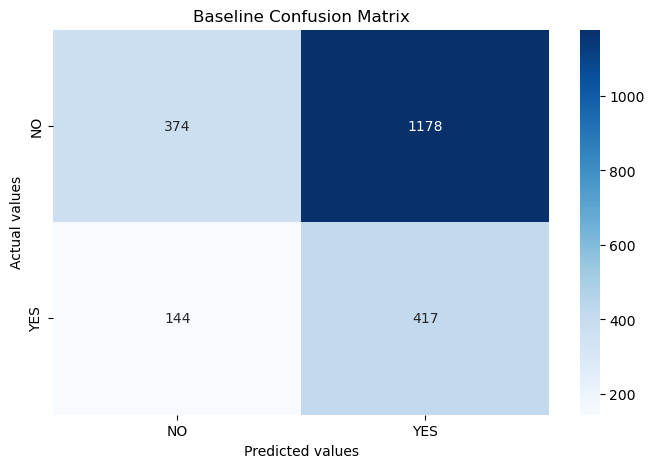

In [37]:
# Confusion Matrix for test set
cm_baseline = confusion_matrix(y_test, baseline_df['Baseline_Predicted_Churn'])
print('Baseline Confusion Matrix:\n', cm_baseline)
plt.figure(figsize=(8, 5))
sns.heatmap(data=cm_baseline, annot=True, fmt='g', cmap="Blues", xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'])
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Baseline Confusion Matrix')
plt.show()

# Comparing Our Model to Baseline

In [38]:
test_metric_df = metric_df[['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']]
test_metric_df

,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,0.85,0.75,0.65,0.7


In [39]:
comparison_metric_df = pd.concat([test_metric_df, metric_df_baseline]).reset_index(drop=True)

In [40]:
comparison_metric_df

,Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,0.85,0.75,0.65,0.70
1,0.37,0.26,0.74,0.39


In [41]:
comparison_metric_df.rename(index={0:(f"{best_model_name}: {best_model_param}"), 1:'Baseline Model'}, inplace=True)

In [42]:
comparison_metric_df

,Test Accuracy,Test Precision,Test Recall,Test F1-Score
"LogisticRegression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.85,0.75,0.65,0.70
Baseline Model,0.37,0.26,0.74,0.39
